In [1]:
import openml
import pandas as pd
import numpy as np
import subprocess
import concurrent.futures
from tqdm.notebook import tqdm
import sys
sys.path.append('../cmake-build-debug')
from KNNRegressor import KNNRegressor
from ConfusionMatrix import ConfusionMatrix
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
from itertools import product

In [2]:
class KNNClassifier(BaseEstimator):
    def __init__(self, 
                 windowSize=1, 
                 windowType="fixed", 
                 distName="euclidean", 
                 kernelName="uniform", 
                 class_encoding="label"):
        self.windowSize = windowSize        
        self.windowType = windowType
        self.distName = distName
        self.kernelName = kernelName
        self.class_encoding = class_encoding
        
        
    def fit(self, X, y):
        params = {
            "windowType": self.windowType, 
            "distName"  : self.distName, 
            "kernelName": self.kernelName, 
            "windowSize": self.windowSize
        }
        self.knnRegressor = KNNRegressor(**params)
        npX = np.array(X)
        npy = np.array(y).reshape(-1)
        
        self.labels_inverse = sorted(list(set(y)))
        self.labels = {label: i for i, label in enumerate(self.labels_inverse)}
        labelsCount = len(self.labels)
        
        if self.class_encoding == "label":
            npy = np.vectorize(self.labels.__getitem__)(npy).astype(np.float).reshape(-1, 1)
        elif self.class_encoding == "onehot":
            def oneHotEncode(c):
                res = np.zeros(labelsCount, dtype=np.float)
                res[self.labels[c]] = 1
                return res
            npy = np.array(list(map(oneHotEncode, npy)))
        
        self.knnRegressor.fit(npX.tolist(), npy.tolist())
    
    
    def predict(self, x):
        npx = np.array(x)
        if (len(npx.shape) == 1):
            npx = [npx]
        y_pred = []
        for xx in npx:
            y_pred.append(self.knnRegressor.predict(xx.tolist())) # rounding
        
        if self.class_encoding == "label":
            y_pred = np.rint(y_pred).astype(np.int)
        if self.class_encoding == "onehot":
            y_pred = np.array(list(map(np.argmax, y_pred)))
        
        res = np.vectorize(self.labels_inverse.__getitem__)(y_pred).reshape(-1)
        return res

In [3]:
X = [[0., 2.],
     [1., 1.],
     [2., 0.]]
y = [1,
     0,
     1]
knn = KNNClassifier(2, windowType="variable", kernelName="gaussian")
knn.fit(X, y)
print(knn.predict([[0, 0], [0, 0]]))
print("")
knn = KNNClassifier(2, windowType="variable", kernelName="gaussian", class_encoding="onehot")
knn.fit(X, y)
print(knn.predict([[0, 0], [0, 0]]))
print("")
knn.set_params(windowSize=2, windowType="fixed", kernelName="uniform")
knn.fit(X, y)
print(knn.predict([[0, 0], [0, 0]]))
print("")

[1 1]

[1 1]

[0 0]



In [4]:
class LeaveOneOut:
    def split(self, X):
        mask = np.full(X.shape[0], False)
        for i in range(X.shape[0]):
            mask[i] = True
            yield ~mask, mask
            mask[i] = False

In [5]:
class ParameterGrid:
    def __init__(self, params):
        if not isinstance(params, list):
            params = [params]
        self.params = params
        
    def __iter__(self):
        for param_dict in self.params:
            param_list = list(param_dict.items())
            names, values = zip(*param_list)
            for value_tuple in product(*values):
                yield dict(zip(names, value_tuple))
                
    def __len__(self):
        res = 0
        for param_dict in self.params:
            prod = 1
            for val in param_dict.values():
                prod *= len(val)
            res += prod
        return res

In [6]:
def f1_score(y_true, y_pred):
    labels = {label: i for i, label in enumerate(set(y_true))}
    labelsCount = len(labels)
    confusionMatrix = np.zeros((labelsCount, labelsCount), dtype=np.int)
    for yt, yp in zip(y_true, y_pred):
        yt = labels[yt]
        yp = labels[yp]
        confusionMatrix[yp][yt] += 1
    confusionMatrix = ConfusionMatrix(confusionMatrix.tolist())
    return confusionMatrix.f1_score_macro()

In [7]:
def cross_validation(estimator, X, y, params_dict):
    loo = LeaveOneOut()
    grid = ParameterGrid(params_dict)
    res = []
    X = np.array(X)
    y = np.array(y)
    for param in tqdm(grid):
        estimator.set_params(**param)
        y_true = []
        y_pred = []
        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            estimator.fit(X_train, y_train)
            y_pred.append(estimator.predict(X_test)[0])
            y_true.append(y_test[0])
        
        score = f1_score(y_true, y_pred)
        param['score'] = score
        res.append(param)
    return pd.DataFrame(res)

In [8]:
def findBestParams(estimator, X, y, params_grid):
    res = cross_validation(estimator, X, y, params_grid)
    best = res.iloc[res['score'].idxmax()]
    return best
    
    
def plotFScore(estimator, X, y, params, num=100):
    params = params.to_dict()
    for key in params:
        params[key] = [params[key]]
    if params['windowType'] == ["fixed"]:
        params['windowSize'] = np.linspace(0, 1, num=num)
    else:
        params['windowSize'] = np.linspace(0, X.shape[0], num=num).astype(np.int)
    del params['score']
    res = cross_validation(estimator, X, y, params)
    scores = res['score']
    windows = res['windowSize']
    plt.figure(figsize=(15, 5))
    plt.plot(windows, scores)
    return res.iloc[res['score'].idxmax()]

In [9]:
# params_grid = {
#     "distName": ["manhattan", "euclidean"],
#     "kernelName": ["uniform"]
# }

# params_grid_fixed = {
#     **params_grid,
#     "windowSize": [0.1, 0.5, 1],
#     "windowType": ["fixed"]
# }

# params_grid_variable = {
#     **params_grid,
#     "windowSize": [1, 2, 5],
#     "windowType": ["variable"]
# }

params_grid = {
    "distName": ["manhattan", "euclidean", "chebyshev"],
    "kernelName": ["uniform", 
                   "triangular", 
                   "epanechnikov", 
                   "quartic",
                   "triweight",
                   "tricube",
                   "gaussian",
                   "cosine",
                   "logistic",
                   "sigmoid"]
}

params_grid_fixed = {
    **params_grid,
    "windowSize": [0.1, 0.5, 1],
    "windowType": ["fixed"]
}

params_grid_variable = {
    **params_grid,
    "windowSize": [1, 2, 5],
    "windowType": ["variable"]
}

params_grid = [params_grid_fixed, params_grid_variable]

In [10]:
DATASET = openml.datasets.get_dataset(1499)
TARGET = 'Class'
# DATASET = openml.datasets.get_dataset(61)
# TARGET = 'class'
X, y, _, _ = DATASET.get_data(target=TARGET)
display(X)
display(y)

,V1,V2,V3,V4,V5,V6,V7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175
...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044


0      1
1      1
2      1
3      1
4      1
      ..
205    3
206    3
207    3
208    3
209    3
Name: Class, Length: 210, dtype: category
Categories (3, object): [1 < 2 < 3]

In [11]:
x_min = X.min()
x_max = X.max()
X_norm = (X - x_min) / (x_max - x_min)

In [12]:
knnSimple = KNNClassifier(class_encoding="label")
knnOneHot = KNNClassifier(class_encoding="onehot")

In [13]:
bestSimple = findBestParams(knnSimple, X_norm, y, params_grid)
bestOneHot = findBestParams(knnOneHot, X_norm, y, params_grid)

distName      euclidean
kernelName      uniform
windowSize            4
windowType     variable
score          0.924389
Name: 2, dtype: object

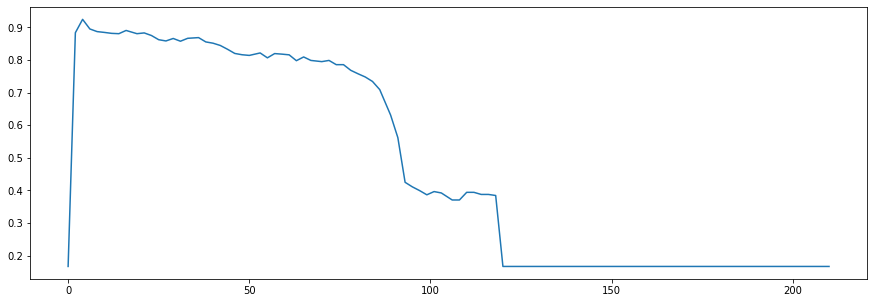

In [15]:
plotFScore(knnSimple, X_norm, y, bestSimple)

distName      euclidean
kernelName      uniform
windowSize            4
windowType     variable
score          0.952481
Name: 2, dtype: object

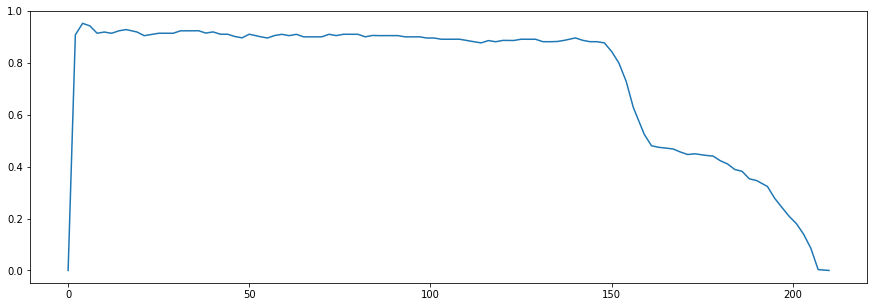

In [16]:
plotFScore(knnOneHot, X_norm, y, bestOneHot)